# Fraudulent Transaction Detection

In [1]:
# Importing Libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import random
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from imblearn.combine import SMOTEENN
import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score

In [2]:
# Reading the data

df = pd.read_csv('Fraud.csv')

In [3]:
# Dataset Info

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [4]:
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


In [5]:
# Data Distribution

type = df['type'].value_counts()
Transaction = type.index
Quantity = type.values
px.pie( df , values = Quantity, names = Transaction, hole = 0.4, title = "Data Distribution by Type" )

## Data Preprocessing

In [6]:
# Checking for Missing/Null Values

df.isnull().values.any()

False

Result: No missing/null values

In [7]:
# Checking for data duplication

df.duplicated().values.any()

False

Result: No duplicated values

In [8]:
# Encoding 'type' column

one_hot_encoded_data = pd.get_dummies(df, columns = ['type'])
type_encoded = pd.get_dummies(df[['type']])
df = pd.concat([df,type_encoded],1)
df.drop('type',1,inplace=True)

In [9]:
df

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0,0,0,0,1,0
1,1,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0,0,0,0,1,0
2,1,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,0,0,0,0,1
3,1,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0,0,1,0,0,0
4,1,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0,0,1,0,0,0
6362616,743,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0,0,0,0,0,1
6362617,743,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0,0,1,0,0,0
6362618,743,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0,0,0,0,0,1


In [10]:
# Checking Multicolinearity

# Checking how many attributes are dtype: object
objList = df.select_dtypes(include = "object").columns
print (objList)

Index(['nameOrig', 'nameDest'], dtype='object')


In [11]:
#Label Encoding for object for conversion
le = LabelEncoder()

for obj in objList:
    df[obj] = le.fit_transform(df[obj].astype(str))

In [12]:
# Dataset Info

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 15 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   amount          float64
 2   nameOrig        int32  
 3   oldbalanceOrg   float64
 4   newbalanceOrig  float64
 5   nameDest        int32  
 6   oldbalanceDest  float64
 7   newbalanceDest  float64
 8   isFraud         int64  
 9   isFlaggedFraud  int64  
 10  type_CASH_IN    uint8  
 11  type_CASH_OUT   uint8  
 12  type_DEBIT      uint8  
 13  type_PAYMENT    uint8  
 14  type_TRANSFER   uint8  
dtypes: float64(5), int32(2), int64(3), uint8(5)
memory usage: 467.2 MB


In [13]:
# Calculating correlation matrix

cols = ['amount','nameOrig','oldbalanceOrg','newbalanceOrig','nameDest','oldbalanceDest','newbalanceDest','isFraud','isFlaggedFraud']
df_1 = df[cols]

corr = df_1.corr()

In [14]:
corr

,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
amount,1.000000,0.000124,-0.002762,-0.007861,-0.169150,0.294137,0.459304,0.076688,0.012295
nameOrig,0.000124,1.000000,-0.000648,-0.000675,-0.000256,0.000245,0.000255,-0.000464,0.000667
oldbalanceOrg,-0.002762,-0.000648,1.000000,0.998803,-0.162688,0.066243,0.042029,0.010154,0.003835
newbalanceOrig,-0.007861,-0.000675,0.998803,1.000000,-0.166489,0.067812,0.041837,-0.008148,0.003776
nameDest,-0.169150,-0.000256,-0.162688,-0.166489,1.000000,-0.198119,-0.203992,-0.021963,-0.001122
oldbalanceDest,0.294137,0.000245,0.066243,0.067812,-0.198119,1.000000,0.976569,-0.005885,-0.000513
newbalanceDest,0.459304,0.000255,0.042029,0.041837,-0.203992,0.976569,1.000000,0.000535,-0.000529
isFraud,0.076688,-0.000464,0.010154,-0.008148,-0.021963,-0.005885,0.000535,1.000000,0.044109
isFlaggedFraud,0.012295,0.000667,0.003835,0.003776,-0.001122,-0.000513,-0.000529,0.044109,1.000000


<AxesSubplot:>

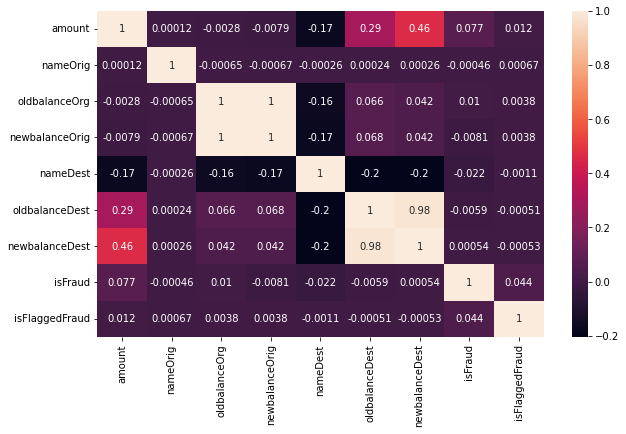

In [15]:
# Correlation Heatmap

plt.figure(figsize=(10,6))
sns.heatmap(corr,annot=True)

Combining oldbalanceOrg with newbalanceOrig and oldbalanceDest with newbalanceDest since they are highly correlated and removing the original individual columns.

In [16]:
# Duplicating dataset

new_df1=df.copy()
new_df1.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,757869,170136.0,160296.36,1662094,0.0,0.0,0,0,0,0,0,1,0
1,1,1864.28,2188998,21249.0,19384.72,1733924,0.0,0.0,0,0,0,0,0,1,0
2,1,181.00,1002156,181.0,0.00,439685,0.0,0.0,1,0,0,0,0,0,1
3,1,181.00,5828262,181.0,0.00,391696,21182.0,0.0,1,0,0,1,0,0,0
4,1,11668.14,3445981,41554.0,29885.86,828919,0.0,0.0,0,0,0,0,0,1,0


In [17]:
# Combining and Dropping Columns

new_df1['Real[Diff]_Amount_Orig'] = new_df1.apply(lambda x: x['oldbalanceOrg'] - x['newbalanceOrig'],axis=1)
new_df1['Real[Diff]_Amount_Dest'] = new_df1.apply(lambda x: x['oldbalanceDest'] - x['newbalanceDest'],axis=1)
new_df1 = new_df1.drop(['oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','step'],axis=1)

In [18]:
new_df1

,amount,nameOrig,nameDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,Real[Diff]_Amount_Orig,Real[Diff]_Amount_Dest
0,9839.64,757869,1662094,0,0,0,0,0,1,0,9839.64,0.00
1,1864.28,2188998,1733924,0,0,0,0,0,1,0,1864.28,0.00
2,181.00,1002156,439685,1,0,0,0,0,0,1,181.00,0.00
3,181.00,5828262,391696,1,0,0,1,0,0,0,181.00,21182.00
4,11668.14,3445981,828919,0,0,0,0,0,1,0,11668.14,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,339682.13,5651847,505863,1,0,0,1,0,0,0,339682.13,-339682.13
6362616,6311409.28,1737278,260949,1,0,0,0,0,0,1,6311409.28,0.00
6362617,6311409.28,533958,108224,1,0,0,1,0,0,0,6311409.28,-6311409.27
6362618,850002.52,2252932,319713,1,0,0,0,0,0,1,850002.52,0.00


In [19]:
# Calculate correlation matrix

cols = ['amount','nameOrig','Real[Diff]_Amount_Orig','Real[Diff]_Amount_Dest','nameDest','isFraud','isFlaggedFraud']
df_2 = new_df1[cols]

corr2 = df_2.corr()

In [20]:
corr2

,amount,nameOrig,Real[Diff]_Amount_Orig,Real[Diff]_Amount_Dest,nameDest,isFraud,isFlaggedFraud
amount,1.000000,0.000124,0.102337,-0.845964,-0.169150,0.076688,0.012295
nameOrig,0.000124,1.000000,0.000686,-0.000130,-0.000256,-0.000464,0.000667
Real[Diff]_Amount_Orig,0.102337,0.000686,1.000000,-0.169292,0.115505,0.362472,0.000230
Real[Diff]_Amount_Dest,-0.845964,-0.000130,-0.169292,1.000000,0.093551,-0.027028,0.000242
nameDest,-0.169150,-0.000256,0.115505,0.093551,1.000000,-0.021963,-0.001122
isFraud,0.076688,-0.000464,0.362472,-0.027028,-0.021963,1.000000,0.044109
isFlaggedFraud,0.012295,0.000667,0.000230,0.000242,-0.001122,0.044109,1.000000


<AxesSubplot:>

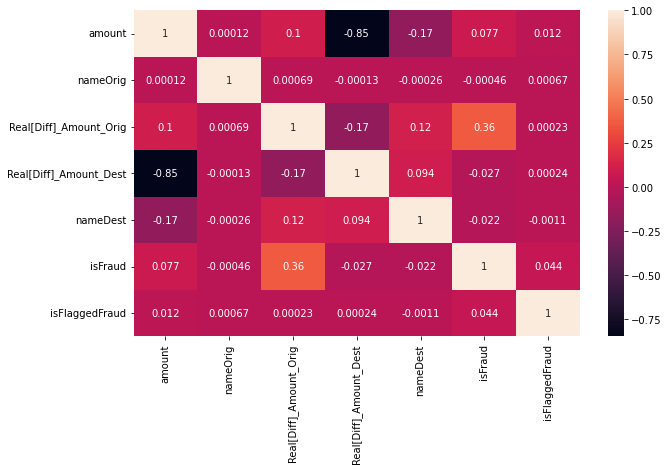

In [21]:
# Correlation Heatmap

plt.figure(figsize=(10,6))
sns.heatmap(corr2,annot=True)

## Model Building

In [22]:
# Scaling

scaler = StandardScaler()
new_df1["NormalizedAmount"] = scaler.fit_transform(new_df1["amount"].values.reshape(-1, 1))
new_df1.drop(["amount"], inplace= True, axis= 1)

Y = new_df1["isFraud"]
X = new_df1.drop(["isFraud","nameOrig","nameDest"],axis= 1)

In [23]:
new_df1

,nameOrig,nameDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,Real[Diff]_Amount_Orig,Real[Diff]_Amount_Dest,NormalizedAmount
0,757869,1662094,0,0,0,0,0,1,0,9839.64,0.00,-0.281560
1,2188998,1733924,0,0,0,0,0,1,0,1864.28,0.00,-0.294767
2,1002156,439685,1,0,0,0,0,0,1,181.00,0.00,-0.297555
3,5828262,391696,1,0,0,1,0,0,0,181.00,21182.00,-0.297555
4,3445981,828919,0,0,0,0,0,1,0,11668.14,0.00,-0.278532
...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,5651847,505863,1,0,0,1,0,0,0,339682.13,-339682.13,0.264665
6362616,1737278,260949,1,0,0,0,0,0,1,6311409.28,0.00,10.153953
6362617,533958,108224,1,0,0,1,0,0,0,6311409.28,-6311409.27,10.153953
6362618,2252932,319713,1,0,0,0,0,0,1,850002.52,0.00,1.109765


In [24]:
# Splitting the data

(X_train, X_test, Y_train, Y_test) = train_test_split(X, Y, test_size= 0.25, random_state= 42)

print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)

Shape of X_train:  (4771965, 9)
Shape of X_test:  (1590655, 9)


In [25]:
# Decision Tree Model

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)

Y_pred_dt = decision_tree.predict(X_test)
decision_tree_score = decision_tree.score(X_test, Y_test) * 100

map = 'summer'
display_labels=['1','0']
cm = confusion_matrix(Y_test,Y_pred_dt)
print("Confusion matrix of Decision Tree model is: \n", cm)

Confusion matrix of Decision Tree model is: 
 [[1587981     629]
 [    579    1466]]


In [26]:
# Random Forest Model

random_forest = RandomForestClassifier(n_estimators= 100)
random_forest.fit(X_train, Y_train)

Y_pred_rf = random_forest.predict(X_test)
random_forest_score = random_forest.score(X_test, Y_test) * 100

map = 'summer'
display_labels=['1','0']
cmR = confusion_matrix(Y_test,Y_pred_rf)
print("Confusion matrix of Random Forest model is: \n", cmR)

Confusion matrix of Random Forest model is: 
 [[1588086     524]
 [    577    1468]]


In [27]:
# AdaBoost Model

AdaB = AdaBoostClassifier()
AdaB.fit(X_train, Y_train)

Y_pred_Ad = AdaB.predict(X_test)
adaboost_score = AdaB.score(X_test, Y_test) * 100

map = 'summer'
display_labels=['1','0']
cmA = confusion_matrix(Y_test,Y_pred_Ad)
print("Confusion matrix of AdaBoost model is: \n", cmA)

Confusion matrix of AdaBoost model is: 
 [[1588385     225]
 [    759    1286]]


In [28]:
# Models' Scores

print("Decision Tree Score: ", decision_tree_score)
print("Random Forest Score: ", random_forest_score)
print("Adaboost Score: ", adaboost_score)

Decision Tree Score:  99.92405644215748
Random Forest Score:  99.93078323080744
Adaboost Score:  99.93813869129384


In [29]:
# Classification Reports of Models

classification_report_dt = classification_report(Y_test, Y_pred_dt)
print("Classification Report - Decision Tree")
print(classification_report_dt)

print("----------------------------------------------------------------------------------------")

classification_report_rf = classification_report(Y_test, Y_pred_rf)
print("Classification Report - Random Forest")
print(classification_report_rf)

print("----------------------------------------------------------------------------------------")

classification_report_Ada = classification_report(Y_test, Y_pred_Ad)
print("Classification Report - AdaBoost")
print(classification_report_Ada)

Classification Report - Decision Tree
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588610
           1       0.70      0.72      0.71      2045

    accuracy                           1.00   1590655
   macro avg       0.85      0.86      0.85   1590655
weighted avg       1.00      1.00      1.00   1590655

----------------------------------------------------------------------------------------
Classification Report - Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588610
           1       0.74      0.72      0.73      2045

    accuracy                           1.00   1590655
   macro avg       0.87      0.86      0.86   1590655
weighted avg       1.00      1.00      1.00   1590655

----------------------------------------------------------------------------------------
Classification Report - AdaBoost
              precision    recall  f1-score   support

    

In [30]:
# AUC Score of Models

auc_score_dt = roc_auc_score(Y_test, Y_pred_dt)
auc_score_rf = roc_auc_score(Y_test, Y_pred_rf)
auc_score_ada = roc_auc_score(Y_test, Y_pred_Ad)

print("AUC Score for Decision Tree is:", auc_score_dt)
print("AUC Score for Random Forest is:", auc_score_rf)
print("AUC Score for AdaBoost is:", auc_score_ada)

AUC Score for Decision Tree is: 0.8582372360121254
AUC Score for Random Forest is: 0.8587592813258701
AUC Score for AdaBoost is: 0.8143546112470054


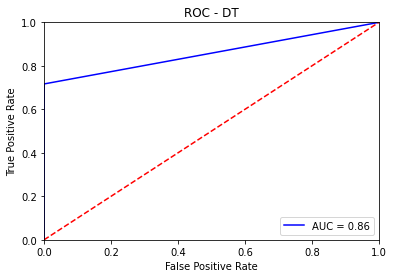

In [31]:
# ROC Curve for Decision Tree Model

fpr, tpr, threshold = metrics.roc_curve(Y_test, Y_pred_dt)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC - DT')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

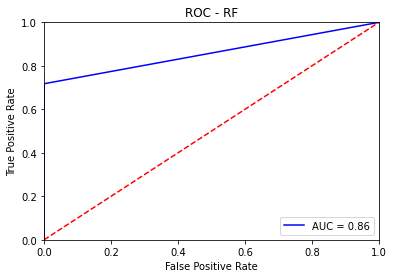

In [32]:
# ROC Curve for Random Forest Model

fpr, tpr, threshold = metrics.roc_curve(Y_test, Y_pred_rf)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC - RF')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

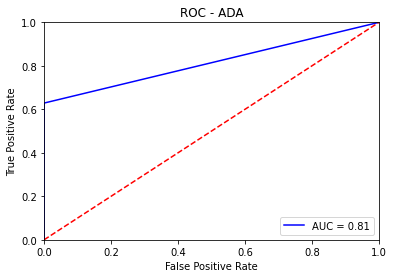

In [33]:
# ROC Cruve for AdaBoost Model

fpr, tpr, threshold = metrics.roc_curve(Y_test, Y_pred_Ad)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC - ADA')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Conclusion

In a Fraudulent Transaction Detection Model, Precision is highly important because rather than predicting normal transactions correctly we want Fraud transactions to be predicted correctly and Legit to be left off. If either of the 2 reasons are not fulfiiled we may catch the innocent and leave the culprit. In the results of the models, it can be seen that various different kinds of metrics give different kinds of results depending on the model. For example, precision value of Adaboost is much better compared to other two models. But in terms of evaluation scores, Random Forest has worked better than other two.

## Questions

#### 1. Data cleaning including missing values, outliers and multi-collinearity.

Done in Data Preprocessing section.

#### 2. Describe your fraud detection model in elaboration.

The fraudulent Transaction Detection Model is a binary classification model that predicts whether a transaction is fraudulent or not. The model is developed using ensemble machine learning algorithms such as decision trees, random forest, and Adaboost. The model is trained on the selected data after doing required data processing and evaluated using various metrics such as precision, recall, and F1-score & AUROC.

#### 3. How did you select variables to be included in the model?

Using Correlation and it's Heatmap.

#### 4. Demonstrate the performance of the model by using best set of tools.

Done in Model Building section.

#### 5. What are the key factors that predict fraudulent customer?

Key factors from the dataset - type of transaction (type), amount of money involved (amount), and before-and-after balances of the relevant accounts (oldbalanceOrg, newbalanceOrig).

#### 6. Do these factors make sense? If yes, How? If not, How not?

Yes, the factors mentioned above do make sense. It's because fraudulent customers tend to make transactions that are significantly different from their normal behavior. For example, a fraudulent customer might make a large or small transaction depending on the fraud case.

#### 7. What kind of prevention should be adopted while company update its infrastructure?

To prevent transactional or other related frauds, the company can adopt various methods such as Monitoring transactions in real-time, Limiting the transaction amount and frequency, Verifying the identity of the customer, Blocking transactions from high-risk locations, Training employees on fraud prevention and keeping a check on both Origin as well as frequent or unusual Destination accounts, etc.

#### 8. Assuming these actions have been implemented, how would you determine if they work?

The effectiveness of the prevention measures can be determined by monitoring the number of fraudulent transactions before and after the implementation of the measures. If the number of fraudulent transactions decrease significantly after the implementation of the measures, then the measures can be considered effective.